# Convolutional Neural Networks

## Project Fun: Write an Algorithm for Jaeger / Kaiju Classification

![](images/test/j1.jpg)  ![](images/test/k99.jpg)

### Steps
Download Datasets and Install Python Modules. Then 

* [Step 1](#step1): Create a CNN to Classify the Characters
* [Step 2](#step2): Use Transfer Learning to Classify Characters
* [Step 3](#step3): Test your Algorithm


Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
### Data loaders for training, validation, and test sets with appropriate transforms, and batch_sizes

import random
import numpy as np

validation_ratio=0.2
batch_size=32

train_loc='data/train'
test_loc='data/test'

train_x = transforms.Compose([transforms.Resize((224,224)), 
                              transforms.RandomHorizontalFlip(),   
                              transforms.ToTensor(), 
                              transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])


test_x = transforms.Compose([transforms.Resize((224,224)), 
                             transforms.ToTensor(),         
                             transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

train_data = datasets.ImageFolder(train_loc, transform=train_x)
test_data = datasets.ImageFolder(test_loc, transform=test_x)



inpsize = list(range(len(train_data)))
np.random.shuffle(inpsize)

split = int(np.floor(validation_ratio * len(train_data)))
train_splt, valid_splt = inpsize[split:], inpsize[:split]


train_sampler = SubsetRandomSampler(train_splt)
valid_sampler = SubsetRandomSampler(valid_splt)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name 

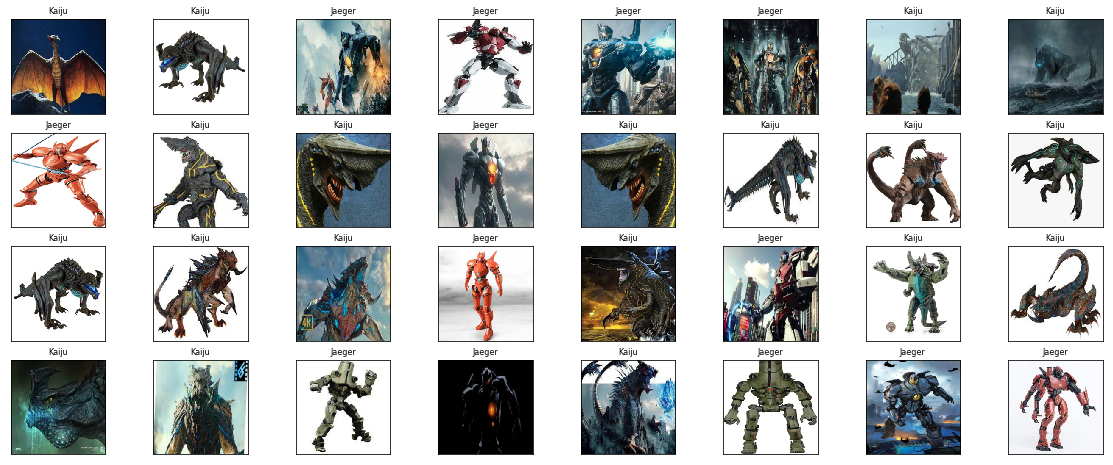

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
         
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))  

images, labels = next(iter(train_loader))

images = images.numpy() 

fig = plt.figure(figsize=(20, 8))

for idx, image in enumerate(images):
    implt = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    implt.set_title(train_data.classes[labels[idx]], wrap=True, fontdict={'fontsize':8});


### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [5]:
import torch.nn as nn
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    return optim.Adam(model.parameters(), lr=0.001)
       

<a id='step2'></a>
### Step 1 Model Architecture

Create a CNN to classify images of the characters.  Use the template in the code cell below.

In [6]:
import torch.nn.functional as F

# define the CNN architecture

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(14*14*128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 50)
        self.drop = nn.Dropout(p=0.2)
    
    def forward(self, x):
        ## Define forward behavior

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 14*14*128)
        
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        
        return x
        
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### Implement the Training Algorithm

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## Find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## Update average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

        ## If the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
               
    return model

### Experiment with the Weight Initialization

Define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## Implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        f = m.in_features
        y = 1.0/np.sqrt(f)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
        
    
model_scratch.apply(custom_weight_init)
model_scratch = train(15, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 2.950006 	Validation Loss: 0.715970
Validation loss decreased (inf --> 0.715970).  Saving model ...
Epoch: 2 	Training Loss: 1.984912 	Validation Loss: 0.849414
Epoch: 3 	Training Loss: 1.072916 	Validation Loss: 0.961569
Epoch: 4 	Training Loss: 0.690513 	Validation Loss: 0.793385
Epoch: 5 	Training Loss: 0.986549 	Validation Loss: 0.917033
Epoch: 6 	Training Loss: 0.928153 	Validation Loss: 0.841764
Epoch: 7 	Training Loss: 0.819232 	Validation Loss: 0.738601
Epoch: 8 	Training Loss: 0.783387 	Validation Loss: 0.732457
Epoch: 9 	Training Loss: 0.885095 	Validation Loss: 0.763369
Epoch: 10 	Training Loss: 0.813714 	Validation Loss: 0.771468
Epoch: 11 	Training Loss: 0.668940 	Validation Loss: 0.706038
Validation loss decreased (0.715970 --> 0.706038).  Saving model ...
Epoch: 12 	Training Loss: 0.511191 	Validation Loss: 0.697328
Validation loss decreased (0.706038 --> 0.697328).  Saving model ...
Epoch: 13 	Training Loss: 0.628853 	Validation Loss: 0.706416
E

### Train and Validate the Model

Run the next code cell to train your model.

In [9]:
num_epochs = 20

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.679263 	Validation Loss: 1.755824
Validation loss decreased (inf --> 1.755824).  Saving model ...
Epoch: 2 	Training Loss: 1.282566 	Validation Loss: 1.058218
Validation loss decreased (1.755824 --> 1.058218).  Saving model ...
Epoch: 3 	Training Loss: 1.284758 	Validation Loss: 2.390527
Epoch: 4 	Training Loss: 1.753505 	Validation Loss: 0.739086
Validation loss decreased (1.058218 --> 0.739086).  Saving model ...
Epoch: 5 	Training Loss: 0.742944 	Validation Loss: 0.870704
Epoch: 6 	Training Loss: 0.858271 	Validation Loss: 0.862147
Epoch: 7 	Training Loss: 0.910252 	Validation Loss: 0.820284
Epoch: 8 	Training Loss: 0.850167 	Validation Loss: 0.740088
Epoch: 9 	Training Loss: 0.790148 	Validation Loss: 0.721604
Validation loss decreased (0.739086 --> 0.721604).  Saving model ...
Epoch: 10 	Training Loss: 0.678911 	Validation Loss: 0.744460
Epoch: 11 	Training Loss: 0.946249 	Validation Loss: 0.709897
Validation loss decreased (0.721604 --> 0.709897).  Savi

### Test the Model

Calculate and print the test loss and accuracy.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.699155


Test Accuracy: 55% (26/47)


---
<a id='step2'></a>
## Step 2: Use Transfer Learning to Classify Characters


### Specify Data Loaders

One for training data, one for validation data, and one for test data. 
Randomly split the images located at `images/train` to create the train and validation data loaders, and use the images located at `images/test` to create the test data loader.

In [11]:
# Data loaders for training, validation, and test sets

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [12]:
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    return optim.Adam(model[1][2].parameters(), lr=0.001) 
    

### Model Architecture

Use transfer learning to create a CNN to classify images of characters.

In [13]:
from torchvision import models

vgg_model = models.vgg19(pretrained=True)

for param in vgg_model.parameters():
    param.requires_grad = False
    
model_transfer = nn.Sequential()

model_transfer.add_module('vgg19', vgg_model)

model_transfer.add_module('features', nn.Sequential(nn.ReLU(inplace=True), nn.Dropout(p=0.5), nn.Linear(1000,50)))
print(model_transfer) 

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 114226058.99it/s]


Sequential(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kernel_size=(3,

### Train and Validate the Model

In [14]:
train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
      criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.751439 	Validation Loss: 1.449533
Validation loss decreased (inf --> 1.449533).  Saving model ...
Epoch: 2 	Training Loss: 1.927266 	Validation Loss: 0.502996
Validation loss decreased (1.449533 --> 0.502996).  Saving model ...
Epoch: 3 	Training Loss: 0.727720 	Validation Loss: 0.304244
Validation loss decreased (0.502996 --> 0.304244).  Saving model ...
Epoch: 4 	Training Loss: 0.242364 	Validation Loss: 0.207347
Validation loss decreased (0.304244 --> 0.207347).  Saving model ...
Epoch: 5 	Training Loss: 0.395796 	Validation Loss: 0.135357
Validation loss decreased (0.207347 --> 0.135357).  Saving model ...
Epoch: 6 	Training Loss: 0.321092 	Validation Loss: 0.070893
Validation loss decreased (0.135357 --> 0.070893).  Saving model ...
Epoch: 7 	Training Loss: 0.262467 	Validation Loss: 0.046648
Validation loss decreased (0.070893 --> 0.046648).  Saving model ...
Epoch: 8 	Training Loss: 0.056251 	Validation Loss: 0.032519
Validation loss decreased (0.04664

### Test the Model

Calculate and print the test loss and accuracy.

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.062713


Test Accuracy: 95% (45/47)


---
<a id='step3'></a>
## Step 3: Prediction Algorithm, Part 1

Implement the function `predict_character`, which accepts a file path to an image and an integer k

In [16]:
import cv2
from PIL import Image

def predict_character(img_path, k):
    image = Image.open(img_path)
    
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()])
                                    
    image= transform(image)
    image.unsqueeze_(0)
  
    if use_cuda:
        image = image.cuda()
        
    model_transfer.eval()  
                                    
    output = model_transfer(image)
    _, index = torch.topk(output.squeeze(0),k)
    class_list = (train_loader.dataset.classes).copy()
    class_list = [x[0:].replace('_',' ') for x in class_list]
    return [class_list[i] for i in index]

# test on a sample image
print ( predict_character('images/test/kk3.jpg', 1) )

['Kaiju']


### Prediction Algorithm, Part 2

In the code cell below, implement the function `suggest_char`, which accepts a file path to an image as input, and then displays the image as predicted by `predict_character`.

In [17]:
def suggest_char(img_path):
    predict_characters = predict_character(img_path, 1)

    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('This could be "{}"'.format(predict_characters[0]))    


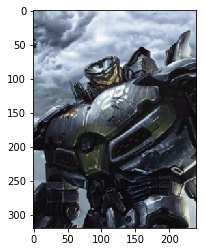

This could be "Jaeger"


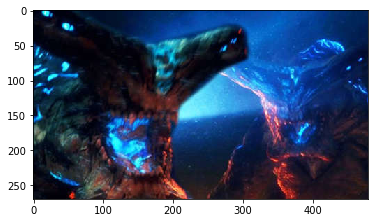

This could be "Kaiju"


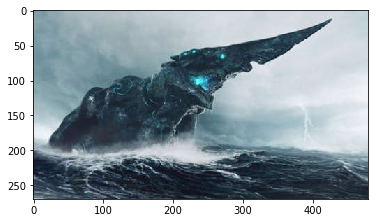

This could be "Kaiju"


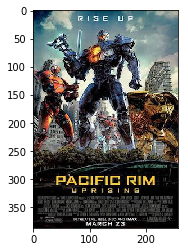

This could be "Kaiju"


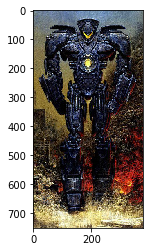

This could be "Jaeger"


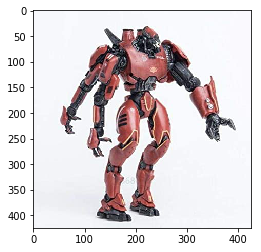

This could be "Jaeger"


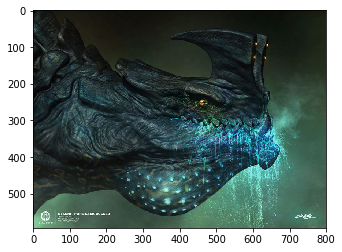

This could be "Kaiju"


In [18]:
 # test on a sample image
suggest_char('images/test/12399.jpg')
suggest_char('images/test/k7.jpg')
suggest_char('images/test/kh.jpg')
suggest_char('images/test/j2.jpg')
suggest_char('images/test/j4.jpg')
suggest_char('images/test/j6.jpg')
suggest_char('images/test/k333.jpg')